In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style('darkgrid')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_set = torchvision.datasets.MNIST(
    root='mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
)

dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

test_set = torchvision.datasets.MNIST(
    root='mnist',
    train=False,
    transform=torchvision.transforms.ToTensor(),
)

test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [3]:
def plot_number(tmp):
    a = tmp.cpu().detach().numpy()
    plt.imshow(a, cmap='binary')
    plt.show()

VAE - loss function

https://www.youtube.com/watch?v=wdKYveLIxgU&list=PLdxQ7SoCLQANizknbIiHzL_hYjEaI-wUe&index=2

https://www.youtube.com/watch?v=Hlr3CYfRMf0&list=PLdxQ7SoCLQANizknbIiHzL_hYjEaI-wUe&index=4

In [4]:
class AEModel(torch.nn.Module):
    def __init__(self):
        super(AEModel, self).__init__()
        # encoder
        self.encoder_conv2d = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.encoder_act = nn.Sigmoid()
        self.encoder_maxpool =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.encoder_flat = nn.Flatten()
        self.encoder_fc_1 = nn.Linear(576, 2)
        self.encoder_fc_2 = nn.Linear(576, 2)
        # decoder
        self.decoder_fc = nn.Linear(2, 576)
        self.decoder_unmaxpool = nn.MaxUnpool2d(kernel_size=2)
        self.decoder_conv_trans = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, output_padding=1)
        self.decoder_act = nn.Sigmoid()
        
    def forward(self, x):
        input_size = x.size()
        x = x.clone()
        
        # add noise
#         plot_number(x[0][0])
#         x += torch.bernoulli(torch.full(input_size, 0.20)).to(device)
#         x += torch.bernoulli(torch.full(input_size, 0.20)).to(device) * 0.5
#         x += torch.bernoulli(torch.full(input_size, 0.20)).to(device) * 0.25
#         x[x>=1] = 1
#         plot_number(x[0][0])

        # encoder
        x = self.encoder_conv2d(x)
        x = self.encoder_act(x)
        x, indices = self.encoder_maxpool(x)
        x = self.encoder_flat(x)
        # if VAE
        mu = self.encoder_fc_1(x)
        s = self.encoder_fc_2(x)
        
        # variation
        e = torch.normal(0, 1, size=(input_size[0], 2)).to(device)
        code = e * torch.exp(s) + mu
        
        # decoder
        x = self.decoder_fc(code)
        x = x.view(-1, 16, 6, 6)
        x = self.decoder_unmaxpool(x, indices)
        x = self.decoder_conv_trans(x)
        x = self.decoder_act(x)
        
        return x, code, mu, s

def train_autoencoder():    
    train_ll, test_ll = [], []
      
    model = AEModel()
    if True:
        model.load_state_dict(torch.load('model.m'), strict=False)
        
    model = model.cuda(device)
    
    loss_f = torch.nn.BCELoss(reduction='sum')

    lr = 1e-4
    optimzer = torch.optim.Adam(model.parameters(), lr=lr)

    for e in range(100):
        for i, (x_i, _) in enumerate(dataloader):
            x_i = x_i.to(device)
            out, _, mu, s = model(x_i)
            
            # VAE loss function
            # close to standard normal distribution
            KL_div = - 0.5 * torch.sum(1 + s - mu.pow(2) - s.exp())
            loss = loss_f(out, x_i) + KL_div
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            if not i%1000:
                print('='*30)
                print(f'epoch: {e}, i: {i}')
                print(f'train loss: {loss.item()}')
                plot_number(x_i[0][0])
                plot_number(out[0][0])
                with torch.no_grad():
                    for index, (x_t, _) in enumerate(test_dataloader):
                        if not index:
                            x_t = x_t.to(device)
                            out, _, mu, s = model(x_t)
                            KL_div = - 0.5 * torch.sum(1 + s - mu.pow(2) - s.exp())
                            test_loss = loss_f(out, x_t) + KL_div
                            train_ll.append(loss.item())
                            test_ll.append(test_loss.item())
                            print(f'train loss: {loss.item()}, test loss: {test_loss.item()}')
    torch.save(model.state_dict(), 'model_.m')
    return model, train_ll, test_ll


epoch: 0, i: 0
train loss: 10354.302734375


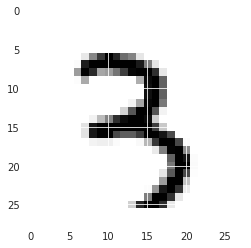

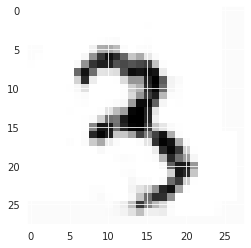

train loss: 10354.302734375, test loss: 10495.14453125
epoch: 1, i: 0
train loss: 10854.6259765625


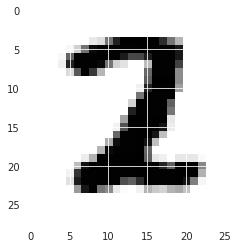

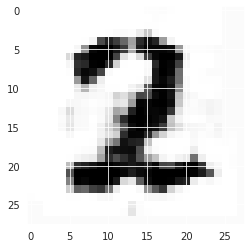

train loss: 10854.6259765625, test loss: 10345.55859375
epoch: 2, i: 0
train loss: 10733.455078125


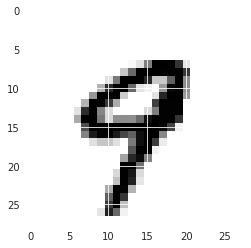

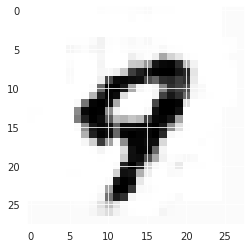

train loss: 10733.455078125, test loss: 10318.8701171875
epoch: 3, i: 0
train loss: 10797.775390625


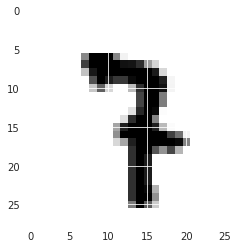

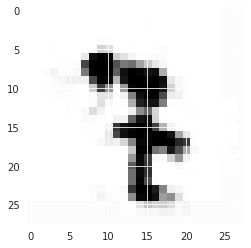

train loss: 10797.775390625, test loss: 10270.8818359375
epoch: 4, i: 0
train loss: 10531.2333984375


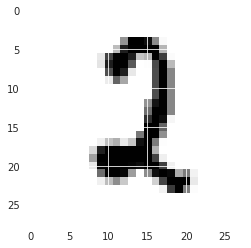

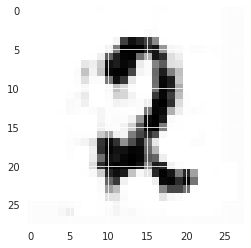

train loss: 10531.2333984375, test loss: 10274.8154296875
epoch: 5, i: 0
train loss: 10073.7138671875


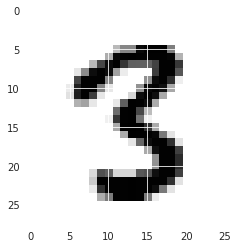

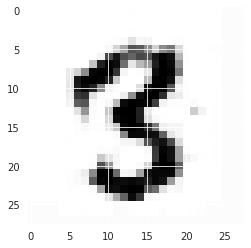

train loss: 10073.7138671875, test loss: 10259.078125
epoch: 6, i: 0
train loss: 11044.171875


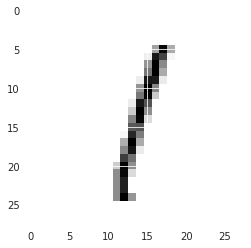

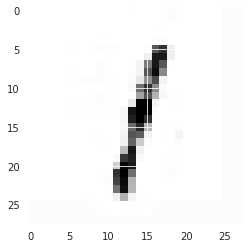

train loss: 11044.171875, test loss: 10252.0947265625
epoch: 7, i: 0
train loss: 10513.3994140625


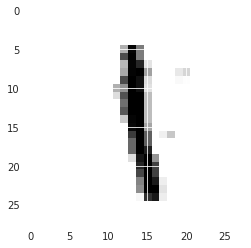

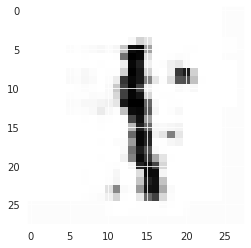

train loss: 10513.3994140625, test loss: 10212.474609375
epoch: 8, i: 0
train loss: 11117.75


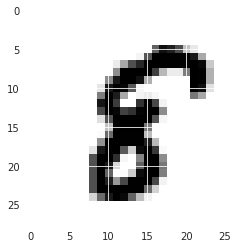

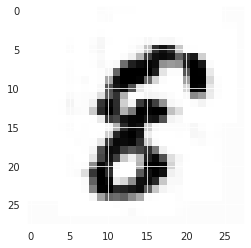

train loss: 11117.75, test loss: 10194.685546875
epoch: 9, i: 0
train loss: 10792.6220703125


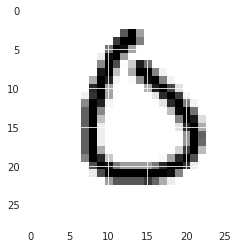

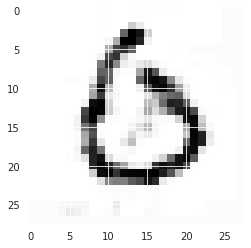

train loss: 10792.6220703125, test loss: 10194.251953125
epoch: 10, i: 0
train loss: 10625.5693359375


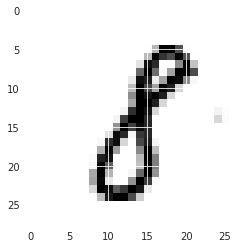

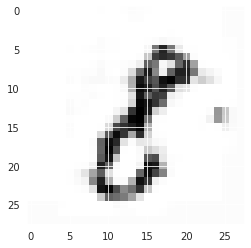

train loss: 10625.5693359375, test loss: 10178.583984375
epoch: 11, i: 0
train loss: 10261.43359375


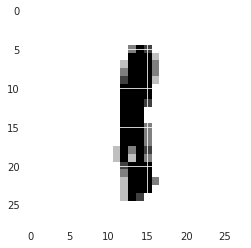

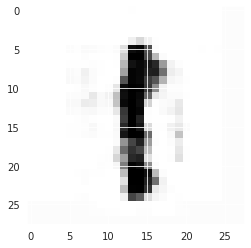

train loss: 10261.43359375, test loss: 10179.3583984375
epoch: 12, i: 0
train loss: 10375.216796875


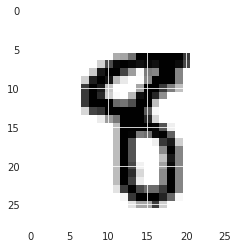

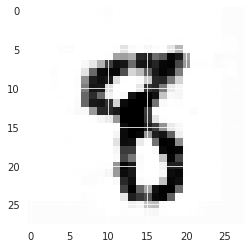

train loss: 10375.216796875, test loss: 10170.5185546875
epoch: 13, i: 0
train loss: 10725.578125


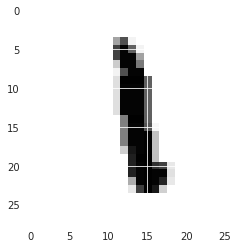

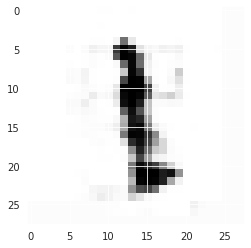

train loss: 10725.578125, test loss: 10171.0576171875
epoch: 14, i: 0
train loss: 10004.5498046875


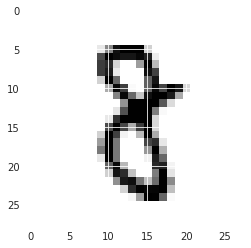

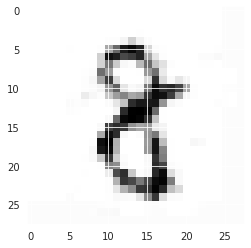

train loss: 10004.5498046875, test loss: 10163.0849609375
epoch: 15, i: 0
train loss: 10726.138671875


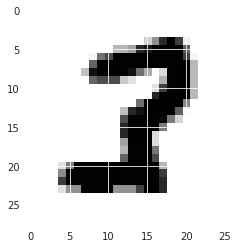

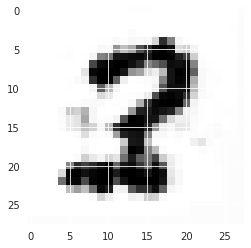

train loss: 10726.138671875, test loss: 10171.828125
epoch: 16, i: 0
train loss: 10577.31640625


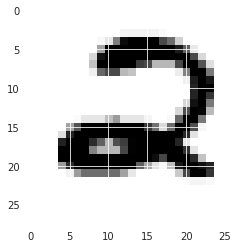

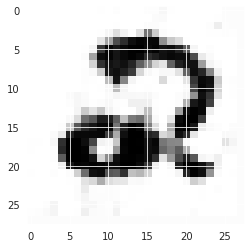

train loss: 10577.31640625, test loss: 10161.4794921875
epoch: 17, i: 0
train loss: 10894.1904296875


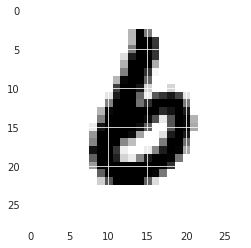

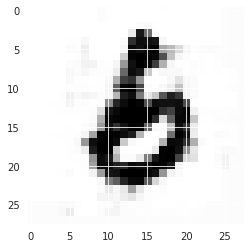

train loss: 10894.1904296875, test loss: 10164.4921875
epoch: 18, i: 0
train loss: 10835.220703125


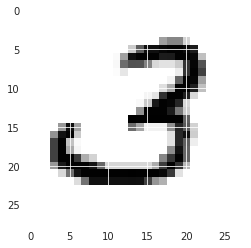

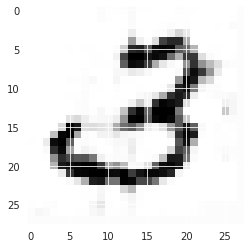

train loss: 10835.220703125, test loss: 10161.9453125
epoch: 19, i: 0
train loss: 10459.50390625


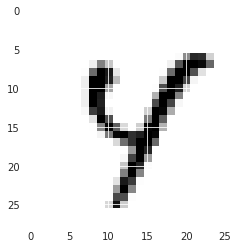

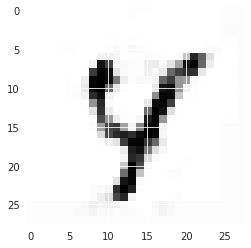

train loss: 10459.50390625, test loss: 10175.8291015625
epoch: 20, i: 0
train loss: 10807.64453125


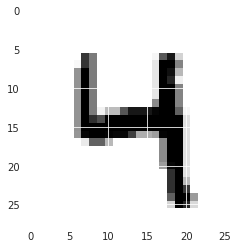

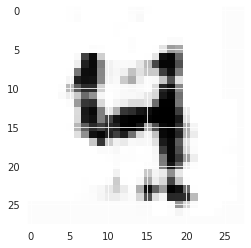

train loss: 10807.64453125, test loss: 10152.736328125
epoch: 21, i: 0
train loss: 10229.0166015625


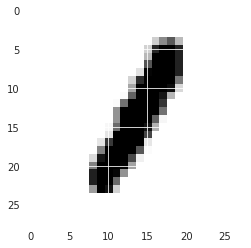

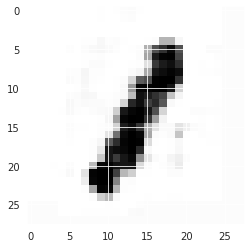

train loss: 10229.0166015625, test loss: 10178.494140625
epoch: 22, i: 0
train loss: 10791.380859375


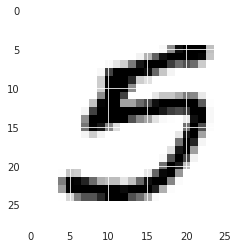

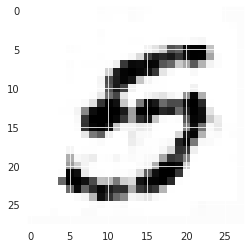

train loss: 10791.380859375, test loss: 10165.298828125
epoch: 23, i: 0
train loss: 10813.7021484375


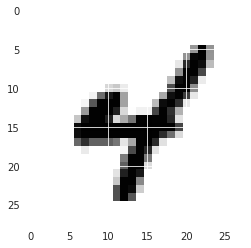

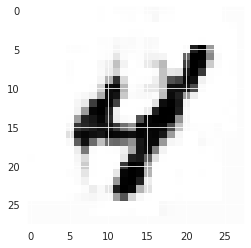

train loss: 10813.7021484375, test loss: 10159.3759765625
epoch: 24, i: 0
train loss: 10760.9384765625


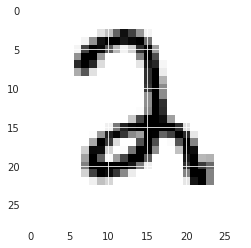

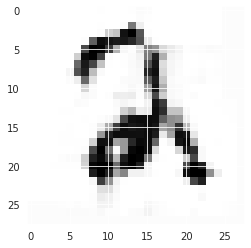

train loss: 10760.9384765625, test loss: 10160.9091796875
epoch: 25, i: 0
train loss: 10061.591796875


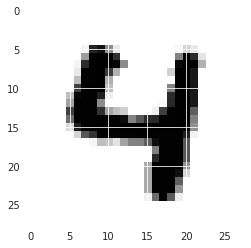

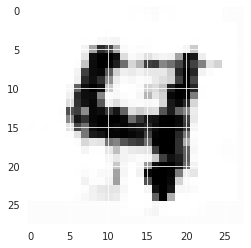

train loss: 10061.591796875, test loss: 10165.220703125
epoch: 26, i: 0
train loss: 10741.068359375


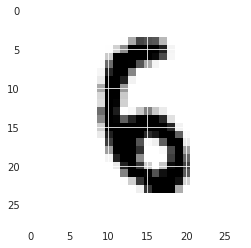

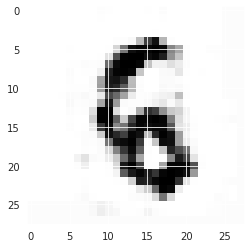

train loss: 10741.068359375, test loss: 10146.27734375
epoch: 27, i: 0
train loss: 10497.45703125


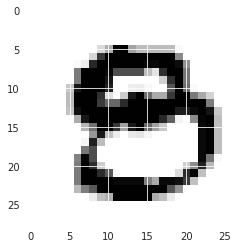

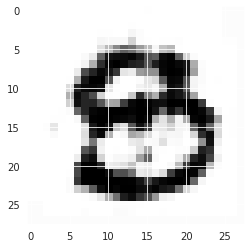

train loss: 10497.45703125, test loss: 10139.5517578125
epoch: 28, i: 0
train loss: 10662.853515625


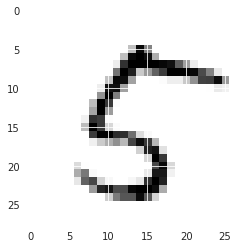

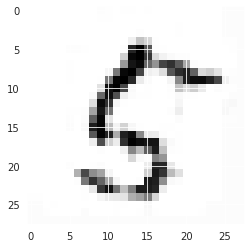

train loss: 10662.853515625, test loss: 10173.181640625
epoch: 29, i: 0
train loss: 10914.3994140625


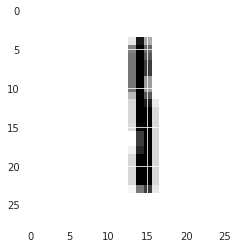

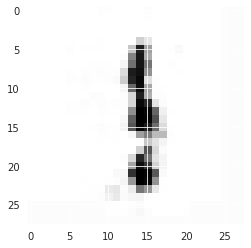

train loss: 10914.3994140625, test loss: 10161.341796875
epoch: 30, i: 0
train loss: 10564.537109375


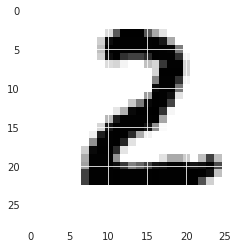

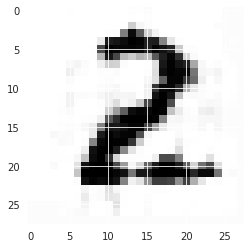

train loss: 10564.537109375, test loss: 10155.5859375
epoch: 31, i: 0
train loss: 10975.8486328125


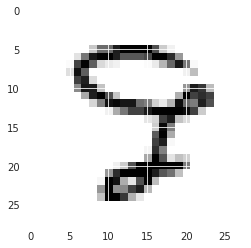

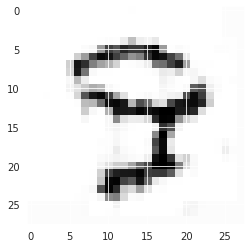

train loss: 10975.8486328125, test loss: 10156.251953125
epoch: 32, i: 0
train loss: 10607.037109375


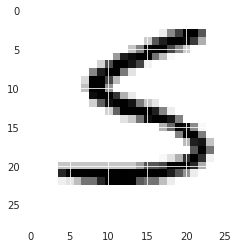

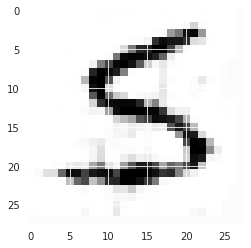

train loss: 10607.037109375, test loss: 10148.5390625
epoch: 33, i: 0
train loss: 10490.00390625


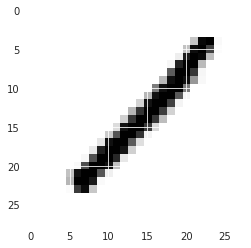

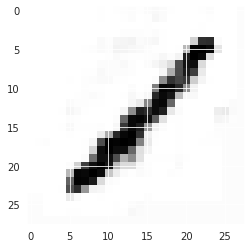

train loss: 10490.00390625, test loss: 10142.732421875
epoch: 34, i: 0
train loss: 10214.1884765625


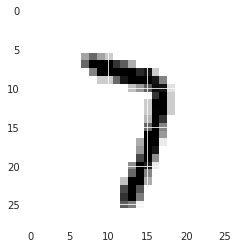

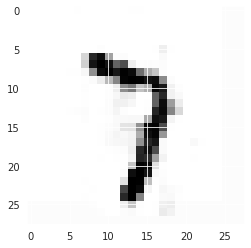

train loss: 10214.1884765625, test loss: 10138.580078125
epoch: 35, i: 0
train loss: 10416.4990234375


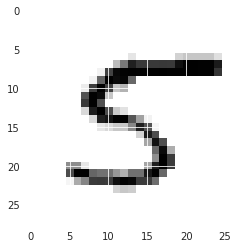

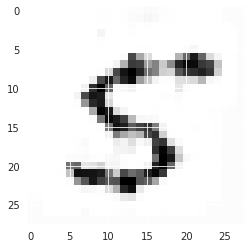

train loss: 10416.4990234375, test loss: 10122.02734375
epoch: 36, i: 0
train loss: 10777.23046875


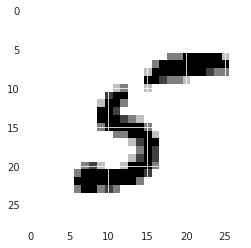

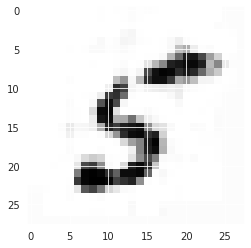

train loss: 10777.23046875, test loss: 10131.4296875
epoch: 37, i: 0
train loss: 10951.7294921875


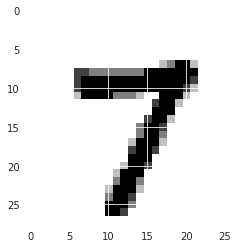

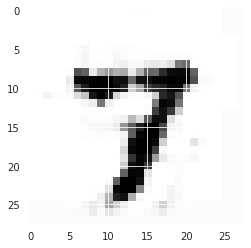

train loss: 10951.7294921875, test loss: 10132.4482421875
epoch: 38, i: 0
train loss: 10256.646484375


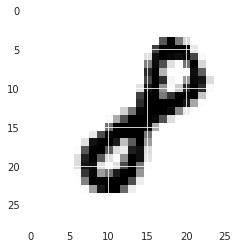

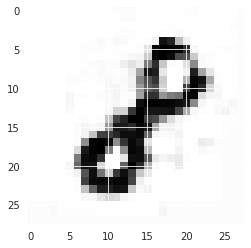

train loss: 10256.646484375, test loss: 10128.8193359375
epoch: 39, i: 0
train loss: 10659.216796875


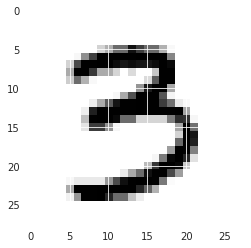

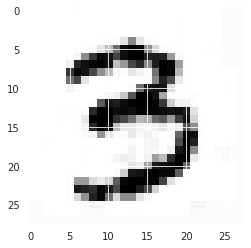

train loss: 10659.216796875, test loss: 10114.6201171875
epoch: 40, i: 0
train loss: 10461.40234375


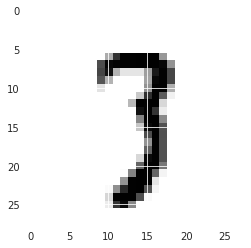

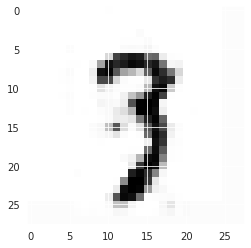

train loss: 10461.40234375, test loss: 10128.1123046875
epoch: 41, i: 0
train loss: 10564.5068359375


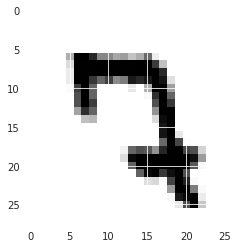

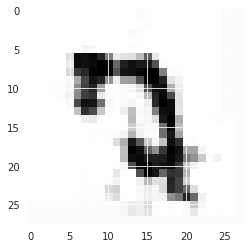

train loss: 10564.5068359375, test loss: 10133.4619140625
epoch: 42, i: 0
train loss: 10289.9716796875


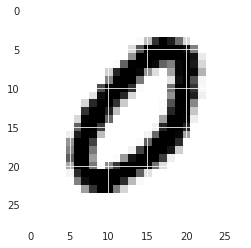

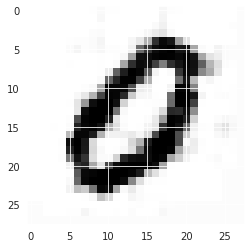

train loss: 10289.9716796875, test loss: 10139.87890625
epoch: 43, i: 0
train loss: 10904.35546875


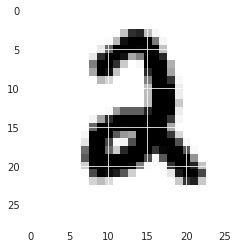

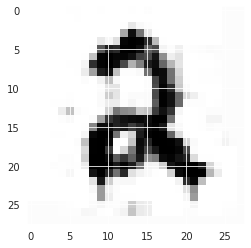

train loss: 10904.35546875, test loss: 10139.3681640625
epoch: 44, i: 0
train loss: 10690.845703125


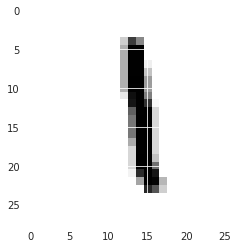

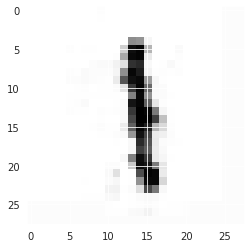

train loss: 10690.845703125, test loss: 10108.69921875
epoch: 45, i: 0
train loss: 10384.4833984375


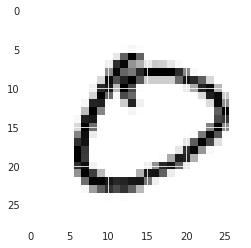

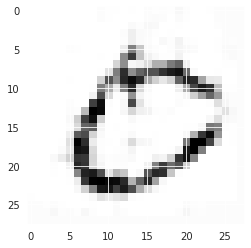

train loss: 10384.4833984375, test loss: 10143.07421875
epoch: 46, i: 0
train loss: 10552.5087890625


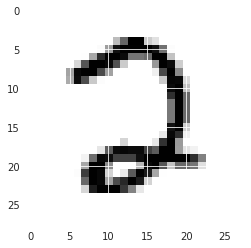

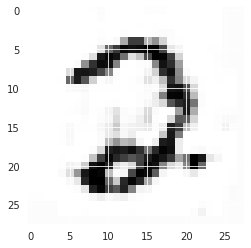

train loss: 10552.5087890625, test loss: 10136.18359375
epoch: 47, i: 0
train loss: 10855.03125


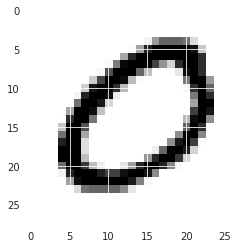

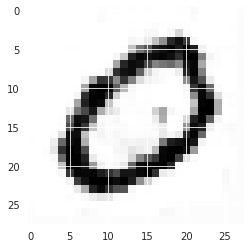

train loss: 10855.03125, test loss: 10134.5283203125
epoch: 48, i: 0
train loss: 11071.44140625


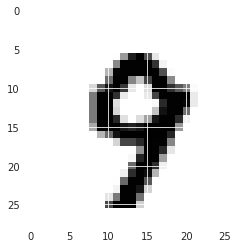

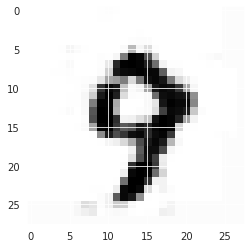

train loss: 11071.44140625, test loss: 10149.65234375
epoch: 49, i: 0
train loss: 10446.51953125


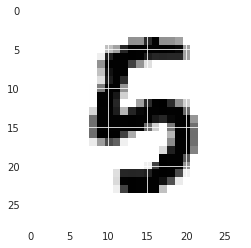

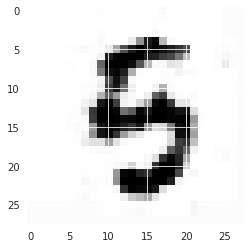

train loss: 10446.51953125, test loss: 10125.0927734375
epoch: 50, i: 0
train loss: 10368.6201171875


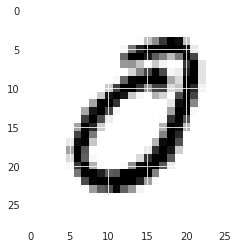

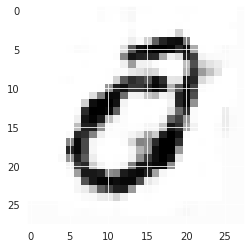

train loss: 10368.6201171875, test loss: 10148.8759765625
epoch: 51, i: 0
train loss: 10659.765625


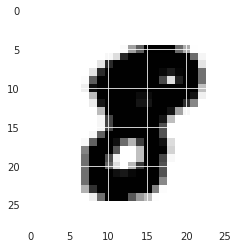

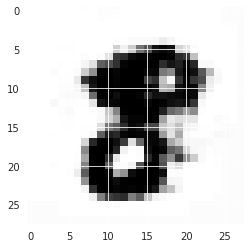

train loss: 10659.765625, test loss: 10118.576171875
epoch: 52, i: 0
train loss: 10453.6826171875


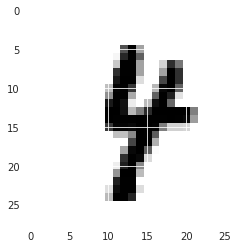

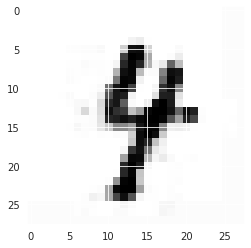

train loss: 10453.6826171875, test loss: 10114.845703125
epoch: 53, i: 0
train loss: 10323.4501953125


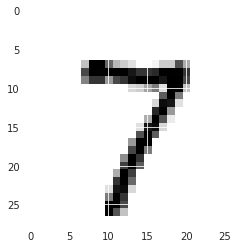

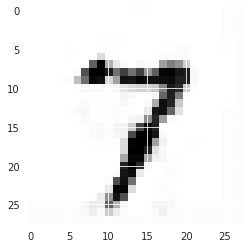

train loss: 10323.4501953125, test loss: 10108.73046875
epoch: 54, i: 0
train loss: 10516.9912109375


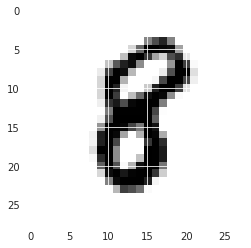

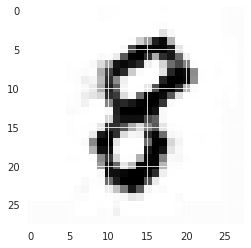

train loss: 10516.9912109375, test loss: 10121.3251953125
epoch: 55, i: 0
train loss: 10765.8505859375


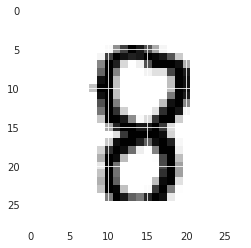

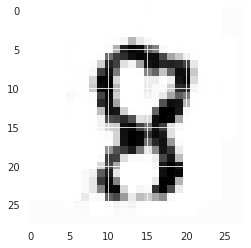

train loss: 10765.8505859375, test loss: 10092.716796875
epoch: 56, i: 0
train loss: 10936.2578125


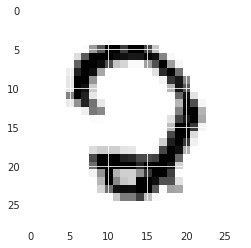

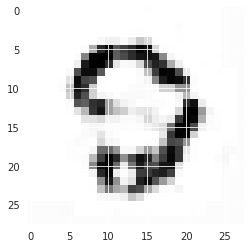

train loss: 10936.2578125, test loss: 10111.81640625
epoch: 57, i: 0
train loss: 10032.8408203125


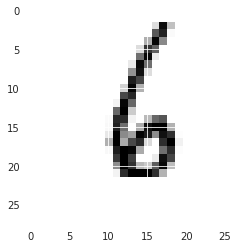

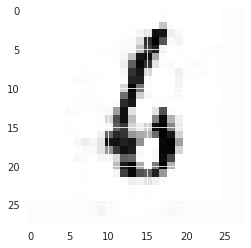

train loss: 10032.8408203125, test loss: 10112.2451171875
epoch: 58, i: 0
train loss: 10453.0361328125


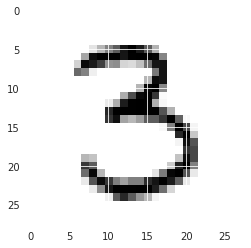

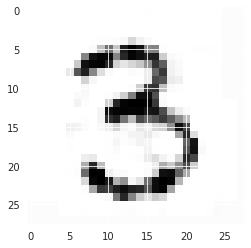

train loss: 10453.0361328125, test loss: 10108.5419921875
epoch: 59, i: 0
train loss: 10291.419921875


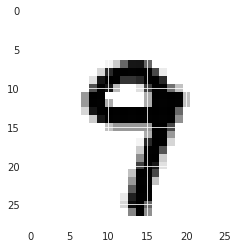

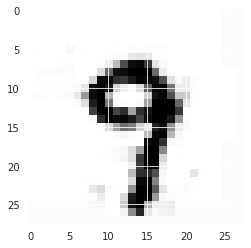

train loss: 10291.419921875, test loss: 10114.4609375
epoch: 60, i: 0
train loss: 10747.6845703125


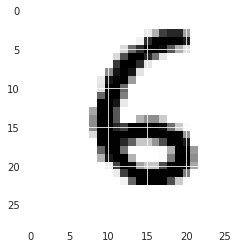

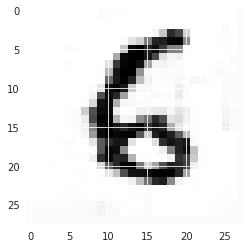

train loss: 10747.6845703125, test loss: 10097.6767578125
epoch: 61, i: 0
train loss: 10922.1240234375


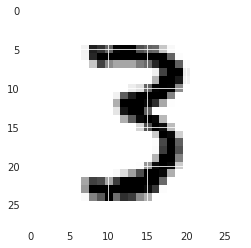

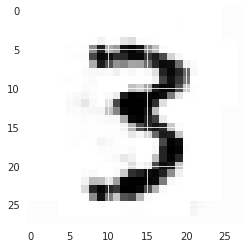

train loss: 10922.1240234375, test loss: 10085.6748046875
epoch: 62, i: 0
train loss: 10595.4091796875


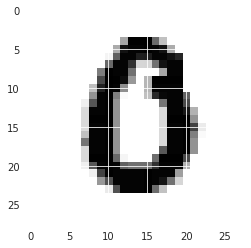

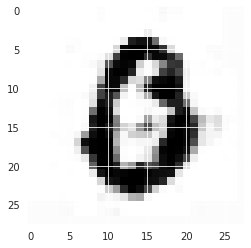

train loss: 10595.4091796875, test loss: 10078.7607421875
epoch: 63, i: 0
train loss: 10235.2392578125


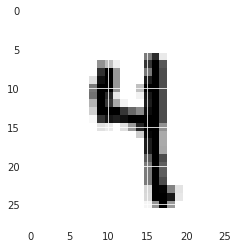

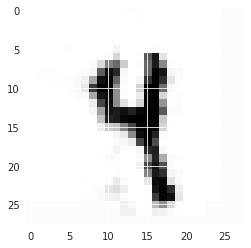

train loss: 10235.2392578125, test loss: 10103.5478515625
epoch: 64, i: 0
train loss: 10630.01171875


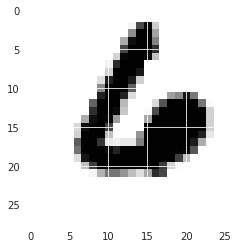

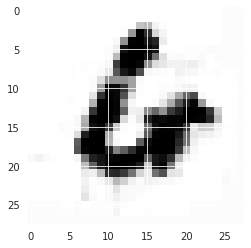

train loss: 10630.01171875, test loss: 10111.7333984375
epoch: 65, i: 0
train loss: 10299.1572265625


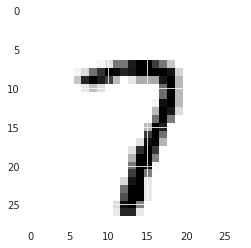

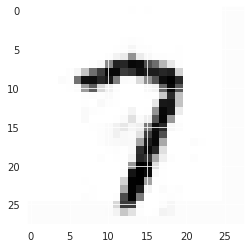

train loss: 10299.1572265625, test loss: 10098.7607421875
epoch: 66, i: 0
train loss: 10330.6240234375


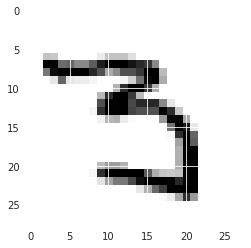

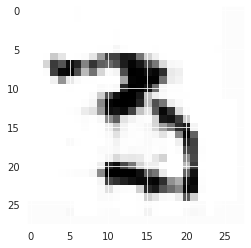

train loss: 10330.6240234375, test loss: 10099.904296875
epoch: 67, i: 0
train loss: 10404.7470703125


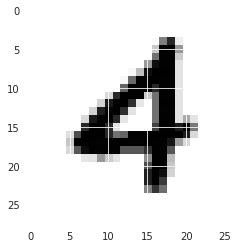

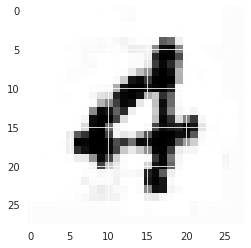

train loss: 10404.7470703125, test loss: 10110.04296875
epoch: 68, i: 0
train loss: 10215.6875


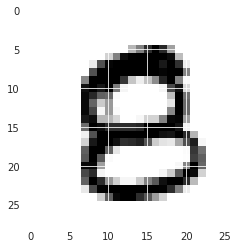

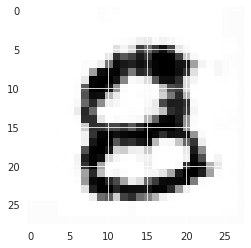

train loss: 10215.6875, test loss: 10080.880859375
epoch: 69, i: 0
train loss: 10314.4853515625


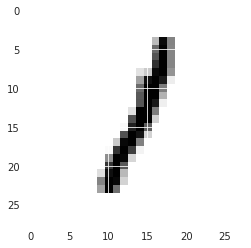

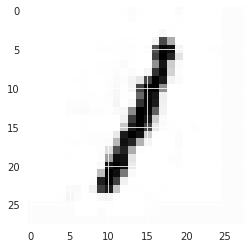

train loss: 10314.4853515625, test loss: 10089.619140625
epoch: 70, i: 0
train loss: 10360.4111328125


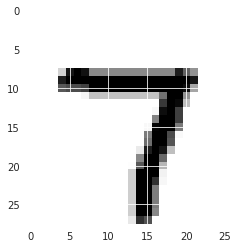

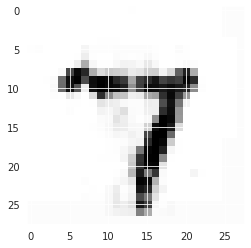

train loss: 10360.4111328125, test loss: 10089.064453125
epoch: 71, i: 0
train loss: 10674.302734375


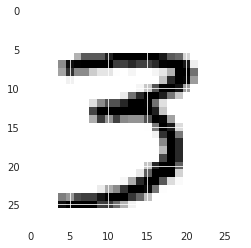

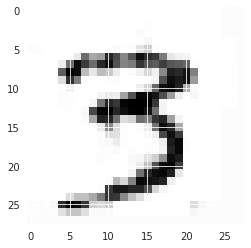

train loss: 10674.302734375, test loss: 10096.171875
epoch: 72, i: 0
train loss: 10517.6015625


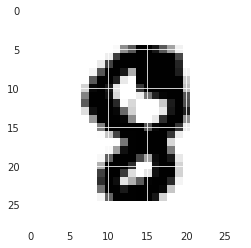

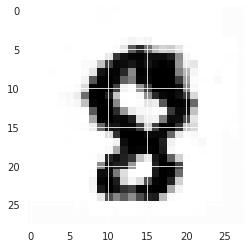

train loss: 10517.6015625, test loss: 10087.408203125
epoch: 73, i: 0
train loss: 10482.9775390625


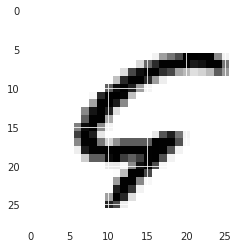

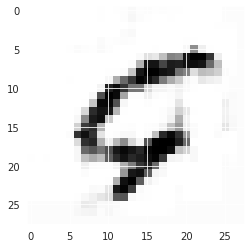

train loss: 10482.9775390625, test loss: 10077.3671875
epoch: 74, i: 0
train loss: 10201.275390625


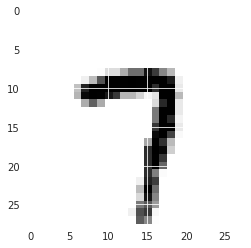

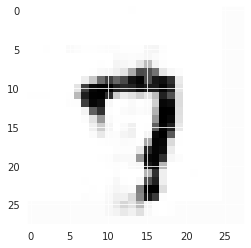

train loss: 10201.275390625, test loss: 10098.7158203125
epoch: 75, i: 0
train loss: 10461.5673828125


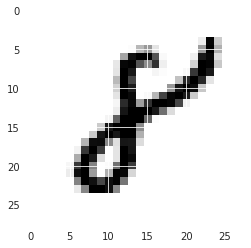

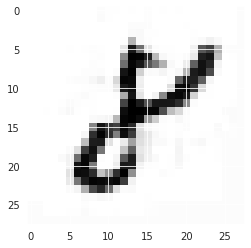

train loss: 10461.5673828125, test loss: 10078.4111328125
epoch: 76, i: 0
train loss: 10477.3916015625


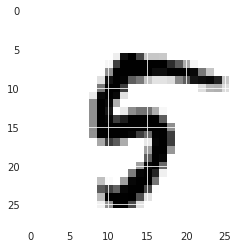

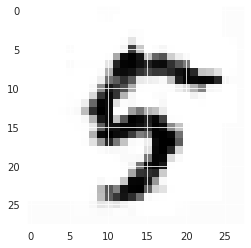

train loss: 10477.3916015625, test loss: 10067.90234375
epoch: 77, i: 0
train loss: 9933.94140625


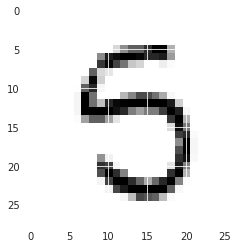

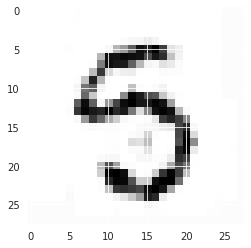

train loss: 9933.94140625, test loss: 10088.3134765625
epoch: 78, i: 0
train loss: 10650.1220703125


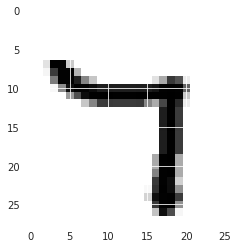

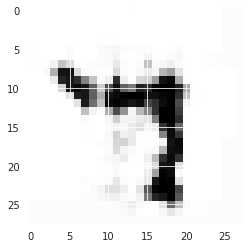

train loss: 10650.1220703125, test loss: 10095.275390625
epoch: 79, i: 0
train loss: 10415.6552734375


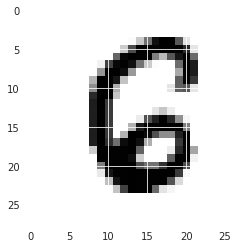

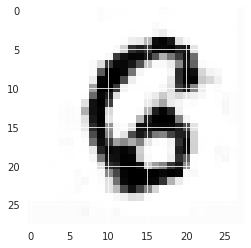

train loss: 10415.6552734375, test loss: 10101.591796875
epoch: 80, i: 0
train loss: 10774.3671875


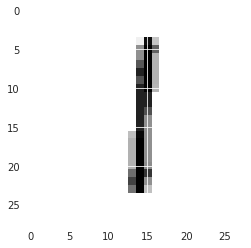

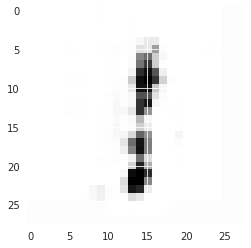

train loss: 10774.3671875, test loss: 10067.25390625
epoch: 81, i: 0
train loss: 10521.8095703125


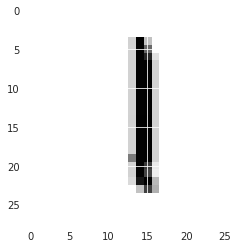

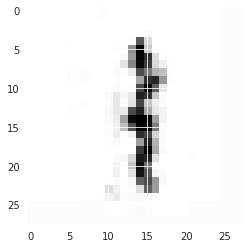

train loss: 10521.8095703125, test loss: 10069.5712890625
epoch: 82, i: 0
train loss: 10534.2314453125


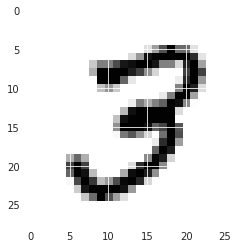

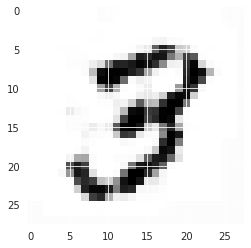

train loss: 10534.2314453125, test loss: 10073.5439453125
epoch: 83, i: 0
train loss: 10672.130859375


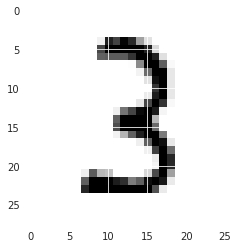

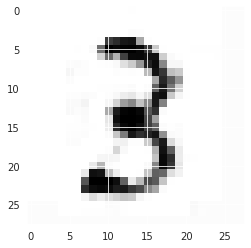

train loss: 10672.130859375, test loss: 10066.4931640625
epoch: 84, i: 0
train loss: 10906.47265625


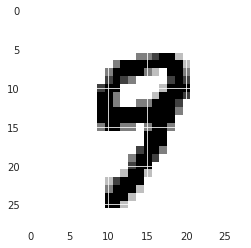

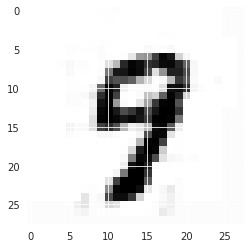

train loss: 10906.47265625, test loss: 10073.1806640625
epoch: 85, i: 0
train loss: 10105.5107421875


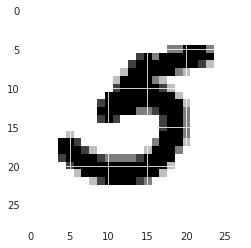

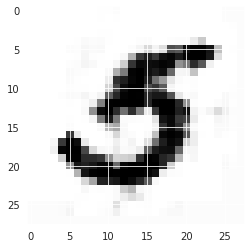

train loss: 10105.5107421875, test loss: 10078.130859375
epoch: 86, i: 0
train loss: 10436.3154296875


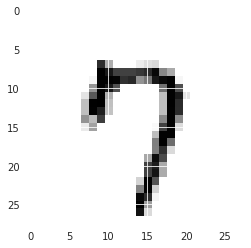

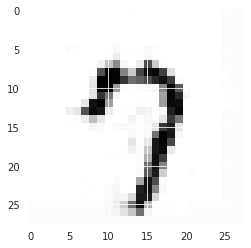

train loss: 10436.3154296875, test loss: 10066.2841796875
epoch: 87, i: 0
train loss: 10489.806640625


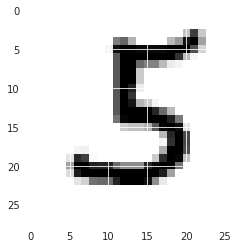

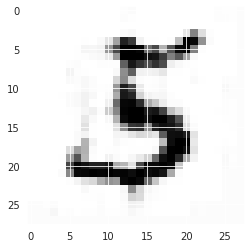

train loss: 10489.806640625, test loss: 10075.166015625
epoch: 88, i: 0
train loss: 10357.5048828125


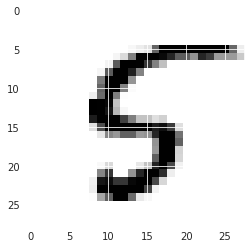

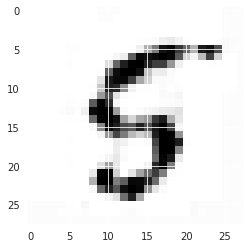

train loss: 10357.5048828125, test loss: 10058.697265625
epoch: 89, i: 0
train loss: 10225.076171875


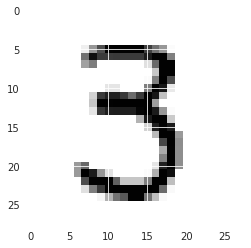

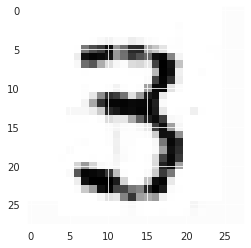

train loss: 10225.076171875, test loss: 10051.69921875
epoch: 90, i: 0
train loss: 10595.826171875


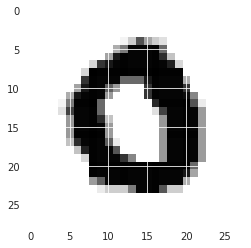

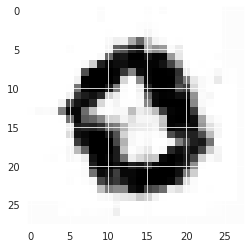

train loss: 10595.826171875, test loss: 10067.3759765625
epoch: 91, i: 0
train loss: 10706.3076171875


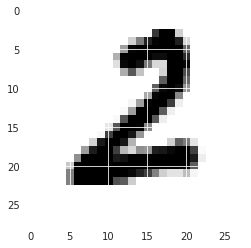

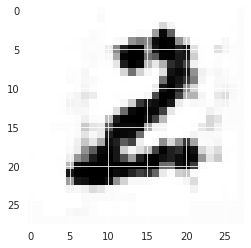

train loss: 10706.3076171875, test loss: 10062.46484375
epoch: 92, i: 0
train loss: 10527.869140625


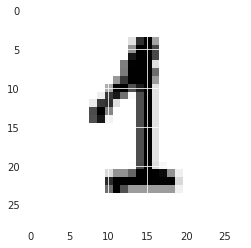

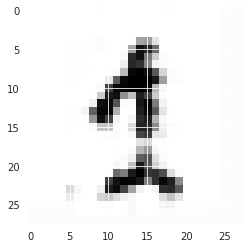

train loss: 10527.869140625, test loss: 10043.1484375
epoch: 93, i: 0
train loss: 10352.6005859375


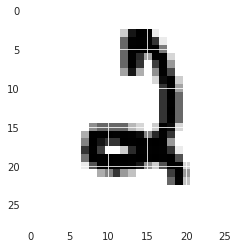

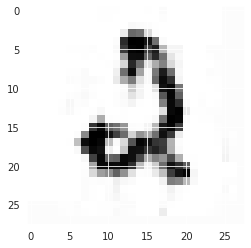

train loss: 10352.6005859375, test loss: 10052.29296875


In [ ]:
model, train_ll, test_ll = train_autoencoder()

In [ ]:
all_data = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)

In [ ]:
for x, y in all_data:
    x = x.to(device)
    _, pred, _, _ = model(x)
    
pred = pred.cpu().detach().numpy()

df = pd.DataFrame(pred, y.numpy())
df.index.name = 'label'
df.columns = ['f_1', 'f_2']

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

sns.scatterplot(data=df, x='f_1', y='f_2', hue='label', legend='full')
plt.savefig('number.png')

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 20]

for i in range(10):
    plt.subplot(5, 2, i+1)
    g = sns.scatterplot(data=df[df.index == i], x='f_1', y='f_2')
    g.title.set_text(i)
    g.xaxis.labelpad = 25
    g.set(ylim=(df['f_2'].min() - 1, df['f_2'].max() + 1), xlim=(df['f_1'].min() - 1, df['f_1'].max() + 1))
plt.savefig('all_number.png')
plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 50
df = pd.DataFrame()
df['train'] = train_ll
df['test'] = test_ll
sns.lineplot(data=df)
plt.savefig('loss.png')
plt.show()